In [1]:
import io
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

# from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [2]:
# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key='e730Htv0I5odT1Mq69n2')

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
CHECKPOINT = "microsoft/Florence-2-large-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [4]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack  of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}
{"image":"IMG_20220316_171515_jpg.rf.e3b1932bb375b3b3912027647586daa8.jpg","prefix":"<OD>","suffix":"5 of clubs<loc_554><loc_2><loc_763><loc_467>6 of clubs<loc_399><loc_79><loc_555><loc_466>7 of clubs<loc_363><loc_484><loc_552><loc_905>8 of clubs<loc_535><loc_449><loc_757><loc_971>"}
{"image":"IMG_20220316_165139_jpg.rf.e30257ec169a2bfdfecb693211d37250.jpg","prefix":"<OD>","suffix":"9 of diamonds<loc_596><loc_535><loc_859><loc_982>jack of diamonds<loc_211><loc_546><loc_411><loc_880>queen of diamonds<loc_430><loc_34><loc_692><loc_518>king of diamonds<loc_223><loc_96><loc_451><loc_523>10 of diamonds<loc_387><loc_542><loc_604><loc_925>"}
{"image":"I

In [4]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path).convert("RGB")
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [5]:
BATCH_SIZE = 8
NUM_WORKERS = 8

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/annotations.jsonl",
    image_directory_path = f"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/processed_data/lucknow_sarath_grid_aa_v3/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/processed_data/wb_grid_400_aa_v1/annotations.jsonl",
    image_directory_path = f"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/processed_data/wb_grid_400_aa_v1/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [6]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

# peft_model = get_peft_model(model, config)
peft_model = model
# peft_model.print_trainable_parameters()

In [7]:
torch.cuda.empty_cache()

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



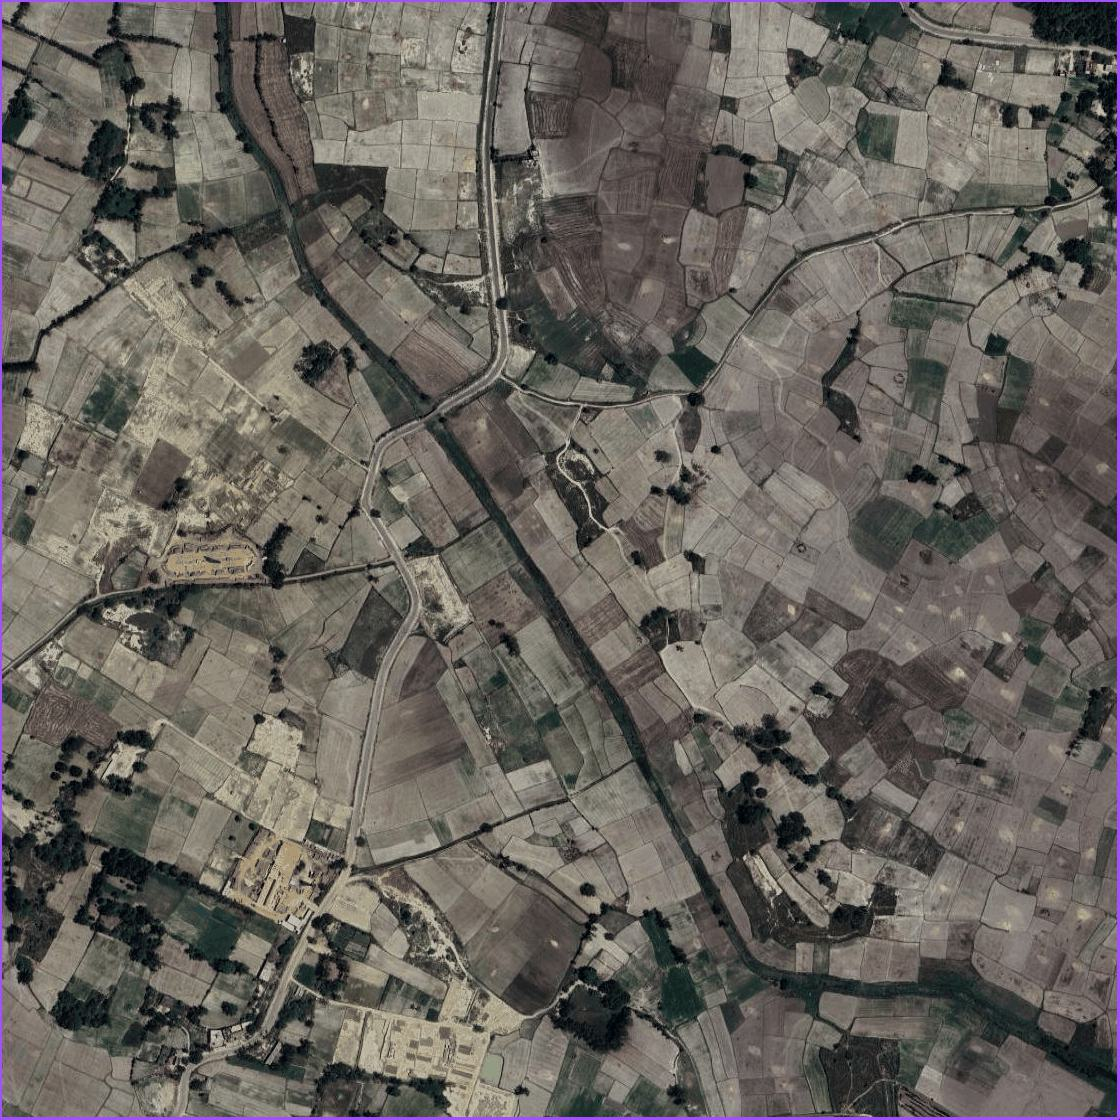
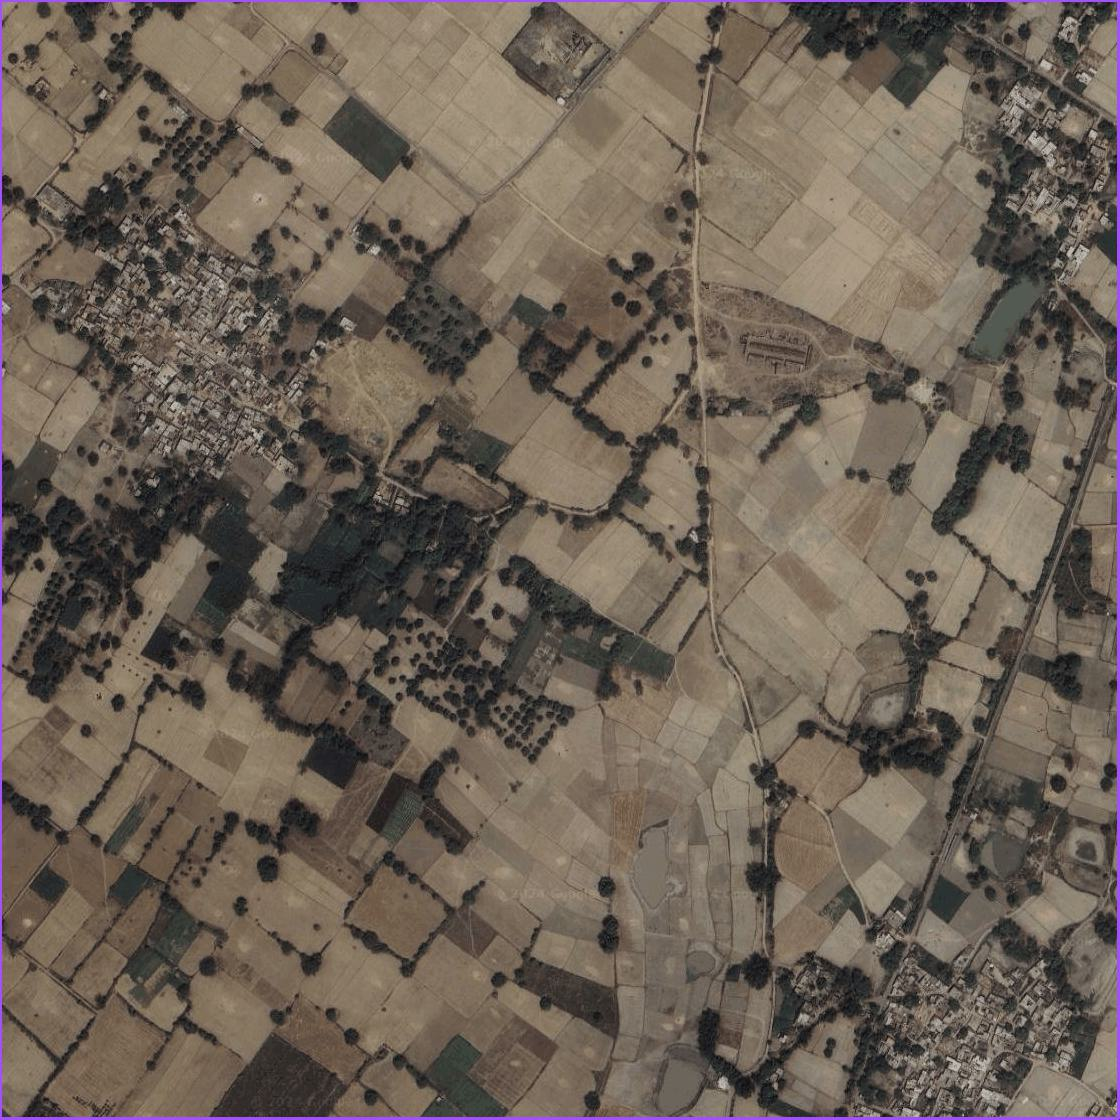
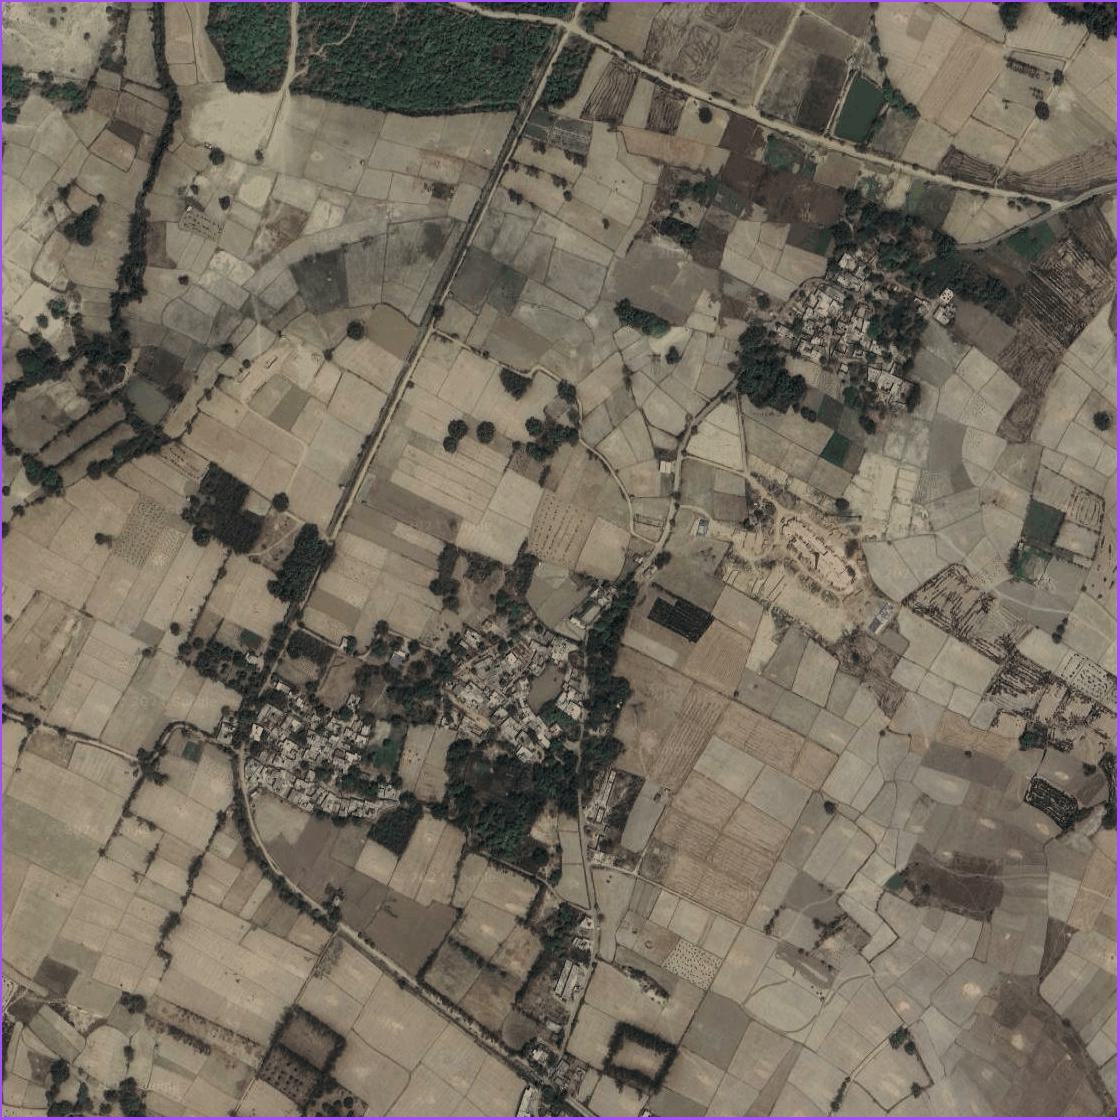
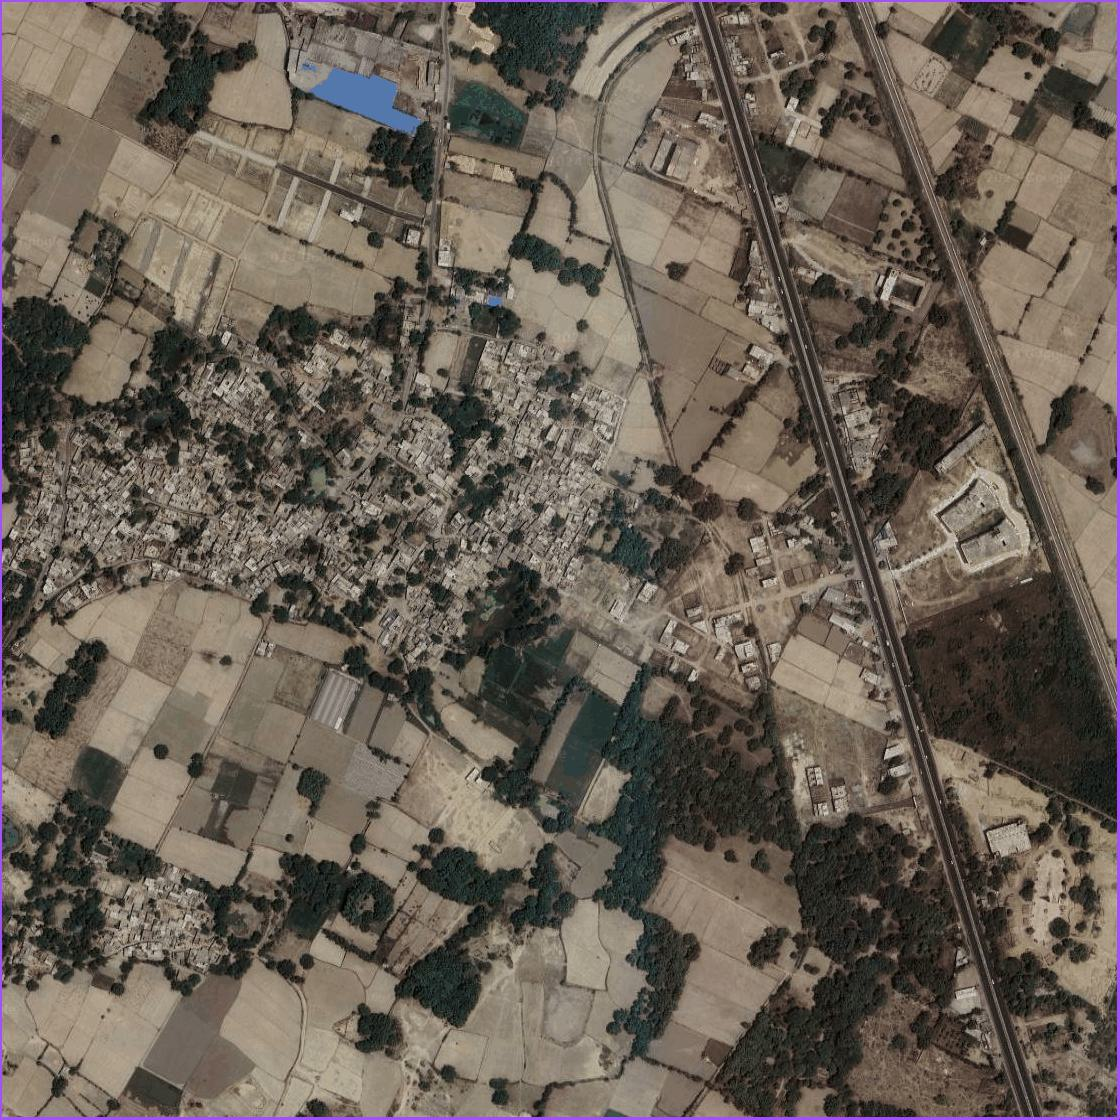

In [9]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(model, val_dataset, 4)

In [10]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # render_inference_results(peft_model, val_loader.dataset, 6)
    losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")
        losses.append(avg_train_loss)

        # model.eval()
        # val_loss = 0
        # with torch.no_grad():
        #     for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

        #         input_ids = inputs["input_ids"]
        #         pixel_values = inputs["pixel_values"]
        #         labels = processor.tokenizer(
        #             text=answers,
        #             return_tensors="pt",
        #             padding=True,
        #             return_token_type_ids=False
        #         ).input_ids.to(DEVICE)

        #         outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        #         loss = outputs.loss

        #         val_loss += loss.item()

        #     avg_val_loss = val_loss / len(val_loader)
        #     print(f"Average Validation Loss: {avg_val_loss}")

        #     render_inference_results(peft_model, val_loader.dataset, 6)

        # Save the model checkpoint every 25 epochs
        if (epoch + 1) % 25 == 0:
            output_dir = f"./model_checkpoints/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)
    
    return losses

In [11]:
%%time

EPOCHS = 100
LR = 5e-6

epoch_loss = train_model(train_loader, val_loader, model, processor, epochs=EPOCHS, lr=LR)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
Training Epoch 1/5:   0%|          | 0/41 [00:00<?, ?it/s]

Training Epoch 1/5: 100%|██████████| 41/41 [02:30<00:00,  3.66s/it]


Average Training Loss: 4.080927287659994


Training Epoch 2/5: 100%|██████████| 41/41 [02:26<00:00,  3.58s/it]


Average Training Loss: 2.296617470136503


Training Epoch 3/5: 100%|██████████| 41/41 [02:24<00:00,  3.53s/it]


Average Training Loss: 1.7421349984843557


Training Epoch 4/5: 100%|██████████| 41/41 [02:25<00:00,  3.54s/it]


Average Training Loss: 1.4978788073469953


Training Epoch 5/5: 100%|██████████| 41/41 [02:26<00:00,  3.57s/it]


Average Training Loss: 1.3457468370111978
CPU times: user 11min 49s, sys: 4min 40s, total: 16min 29s
Wall time: 12min 41s


Text(0, 0.5, 'Loss')

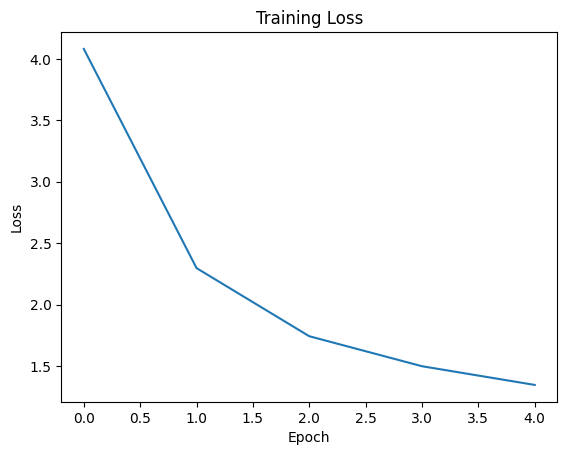

In [13]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [8]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


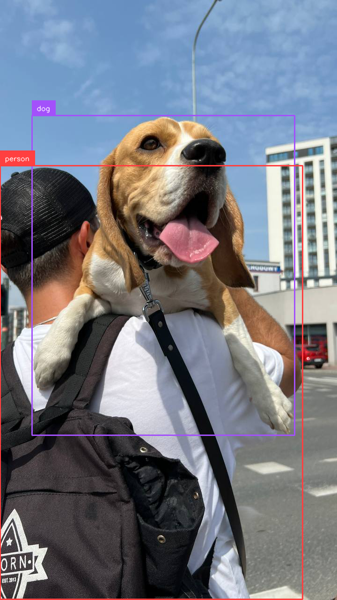

In [9]:
# @title Check if the model can still detect objects outside of the custom dataset

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
model

In [10]:
PATTERN = r'([a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

In [11]:
val_dataset[0]

('<OD>',
 'FCBK<loc_221><loc_177><loc_317><loc_251>',
 <PIL.Image.Image image mode=RGB size=1120x1120>)

In [12]:
extract_classes(val_dataset)

['FCBK', 'Zigzag']

In [13]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


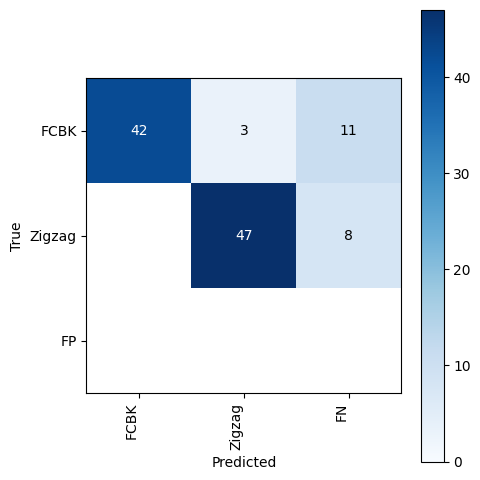

In [20]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot(fig_size=(5,5))